# Import version1 data and module

In [1]:
'''import module'''

# basic tool
import os
from functools import reduce
import random

# model persistent
import pickle

# data process and visualization
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from feature_selector import FeatureSelector

# style and text
from matplotlib.font_manager import FontProperties

# fit model

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# evaluation
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.model_selection import KFold

# tune
from sklearn.model_selection import GridSearchCV

%matplotlib inline

In [2]:
# fit function
# case輸入字串
# svm_ornot是否配適svm=>True:是,other:否
def fit_models(X_train, X_test, y_train, y_test, case, svm_ornot=False):
    
    # Logistic regression
    logmodel = LogisticRegression()
    logmodel.fit(X_train, y_train)
    print("-------------Logistic regression配適完成-----------------")
    pred_log = logmodel.predict_proba(X_test)
    auroc_log = roc_auc_score(y_test, pred_log[:, 1])
    print("-------------Logistic regression預測完成-----------------")
    
    # knn
    knn = KNeighborsClassifier()
    knn.fit(X_train, y_train)
    print("-------------knn配適完成-----------------")
    pred_knn = knn.predict_proba(X_test)
    auroc_knn = roc_auc_score(y_test, pred_knn[:, 1])
    print("-------------knn預測完成-----------------")
    
    # random forest
    rf = RandomForestClassifier(n_estimators=600)
    rf.fit(X_train, y_train)
    print("-------------rf配適完成-----------------")
    pred_rf = rf.predict_proba(X_test)
    auroc_rf = roc_auc_score(y_test, pred_rf[:, 1])
    print("-------------rf預測完成-----------------")
    
    # XGBOOST
    xgb = XGBClassifier()
    xgb.fit(X_train, y_train)
    print("-------------xgb配適完成-----------------")
    pred_xgb = xgb.predict_proba(X_test)
    auroc_xgb = roc_auc_score(y_test, pred_xgb[:, 1])
    print("-------------xgb預測完成-----------------")
    
    # SVM(維度太高了電腦跑不動)
    if svm_ornot == True:
        svm = SVC(probability=True)
        svm.fit(X_train, y_train)
        print("-------------svc配適完成-----------------")
        pred_svm = svm.predict_proba(X_test)
        auroc_svm = roc_auc_score(y_test, pred_svm[:, 1])
        print("-------------svc預測完成-----------------")
    else:
        print("-------------不執行svm-----------------")
        pred_svm = False
        auroc_svm = False
        svm = False
    
    
    # inspection order
    print("")
    print("--------------------------------------------")
    print("類別順序log:", logmodel.classes_)
    print("類別順序knn:", knn.classes_)
    print("類別順序rf:", rf.classes_)
    print("類別順序xgb:", xgb.classes_)
    if svm_ornot == True:
        print("類別順序svm:", svm.classes_)
    else:
        print("類別順序svm:未配適")
    print("--------------------------------------------")
    print("")
    
    # call write_out_auroc
    write_out_auroc(auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm, case)
    
    # call write_out_prob
    write_out_prob(pred_log, pred_knn, pred_rf, pred_xgb, pred_svm, case)
    
    # call write_out_model
    write_out_model(logmodel, knn, rf, xgb, svm, case)
    
    
def write_out_auroc(auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm, case):
    
    # make df
    if auroc_svm is False:
        result_auroc = pd.DataFrame([[auroc_log, auroc_knn, auroc_rf, auroc_xgb, None]], 
                                    columns=["log", "knn", "rf", "xgb", "svm"])
    else:
        result_auroc = pd.DataFrame([[auroc_log, auroc_knn, auroc_rf, auroc_xgb, auroc_svm]], 
                                    columns=["log", "knn", "rf", "xgb", "svm"])
    
    # write out
    result_auroc.to_csv(case + "_auroc.csv", index=False)
    print("auroc資料順利傳出")
    
    
def write_out_prob(pred_log, pred_knn, pred_rf, pred_xgb, pred_svm, case):
    
    # make df
    df1 = pd.DataFrame(pred_log,columns=[("log", 0), ("log", 1)])
    df2 = pd.DataFrame(pred_knn,columns=[("knn", 0), ("knn", 1)])
    df3 = pd.DataFrame(pred_rf,columns=[("rf", 0), ("rf", 1)])
    df4 = pd.DataFrame(pred_xgb,columns=[("xgb", 0), ("xgb", 1)])
    if type(pred_svm) == bool:
        df5 = pd.DataFrame(None,columns=[("svm", 0), ("svm", 1)])
    else:
        df5 = pd.DataFrame(pred_svm,columns=[("svm", 0), ("svm", 1)])
    
    result_prob = pd.concat([df1, df2, df3, df4, df5], axis=1)
    result_prob.columns = pd.MultiIndex.from_tuples(result_prob.columns, names=['Method','class'])
    
    # write out
    result_prob.to_csv(case + "_prob.csv", index=False)
    print("prob資料順利傳出")
    
def write_out_model(logmodel, knn, rf, xgb, svm, case):
    
    model = [logmodel, knn, rf, xgb]
    filename = ["logmodel_" + case, "knn_" + case, "rf_" + case, "xgb_" + case]
    if svm != False:
        model.append(svm)
        filename.append("svm_" + case)
                
    # dump model(write out)
    for (mod, fil_name) in zip(model, filename): 
        pickle.dump(mod, open(fil_name, 'wb'))
    
    print("model順利儲存")
    

In [3]:
# draw chart
## pred_table:table of result
##  othercurve=DF(格式同pred_table)
# 使用前請確保y_test的值

def draw_chart(pred_table, case, svm_ornot=False, othercurve=False):
    # set font
    font_content = FontProperties(size=20)
    font_title = FontProperties(size=25)
    
    # data
    fpr1, tpr1, thresholds1 = roc_curve(y_test, pred_table["log"]["1"], pos_label=1)
    fpr2, tpr2, thresholds2 = roc_curve(y_test, pred_table["knn"]["1"], pos_label=1)
    fpr3, tpr3, thresholds3 = roc_curve(y_test, pred_table["rf"]["1"], pos_label=1)
    fpr4, tpr4, thresholds4 = roc_curve(y_test, pred_table["xgb"]["1"], pos_label=1)
    if svm_ornot == True:    
        fpr5, tpr5, thresholds5 = roc_curve(y_test, pred_table["svm"]["1"], pos_label=1)
        
        
    xstandard = np.linspace(0, 1, 10)

    fig = plt.figure(figsize=[7, 5])
    ax = fig.add_axes([0, 0, 1, 1])
    ax.plot(xstandard, xstandard, "--")
    ax.plot(fpr1, tpr1, label="log")
    ax.plot(fpr2, tpr2, label="knn")    
    ax.plot(fpr3, tpr3, label="rf")
    ax.plot(fpr4, tpr4, label="xgb")
    if svm_ornot==True:
        ax.plot(fpr5, tpr5, label="svm")
        
    # othercurve
    if othercurve is not False:
        #　加入othercurve
        pred_table = pd.concat([pred_table, othercurve], axis=1)
        # 刪除以配置好欄位
        pred_table = pred_table.drop(["log", "knn", "rf", "xgb", "svm"],axis=1)
        
        count = 0
        for (i,j) in pred_table.columns:
            count = count + 1
            # 是偶數(避免重複)(因奇偶數同)
            if count % 2 == 0:
                fpr, tpr, thresholds = roc_curve(y_test, pred_table[i][1], pos_label=1)
                ax.plot(fpr, tpr, label=i)

    # design
    ax.set_title("ROC curve(" + case + ")", fontproperties=font_title)
    ax.set_xlabel("False Positive Rate", fontproperties=font_content)
    ax.set_ylabel("True Positive Rate", fontproperties=font_content)
    ax.legend(fontsize="xx-large", loc=4)
    
    plt.show()

In [4]:
# working dir
working_path = r"D:\mypython_d\Cathay_Big_data_competition_2019"
os.chdir(working_path)

In [5]:
# set figure style
sns.set_style("whitegrid")
# set text
font = FontProperties(fname=r"c:\windows\Fonts\msjh.ttc")
font_heavy = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc")
font_big = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc", size= "x-large")
font_kibig = FontProperties(fname=r"c:\windows\Fonts\msjhbd.ttc", size= "large")

In [6]:
# import data
train_v1 = pd.read_csv("train_cleaned_version1.csv", low_memory=False, index_col=0)
test_v1 = pd.read_csv("test_cleaned_1.csv", low_memory=False, index_col=0)

In [7]:
train_v1["Y1"].value_counts()

0    97827
1     1931
Name: Y1, dtype: int64

In [9]:
1931*100 / (97827 + 1931)

1.9356843561418633

# Train_test_split

In [62]:
X = train_v1.drop("Y1", axis=1)
y = train_v1["Y1"]

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [64]:
# 驗證分層抽樣比例
print(y_train.value_counts())
print(y_test.value_counts())
print("y_train 0比例:",65543*100/(65543 + 1294) )
print("y_train 1比例:",1294*100/(65543 + 1294) )
print("y_test 0比例:", 32284*100/(32284 + 637))
print("y_test 1比例:", 637*100/(32284 + 637))

0    65543
1     1294
Name: Y1, dtype: int64
0    32284
1      637
Name: Y1, dtype: int64
y_train 0比例: 98.06394661639511
y_train 1比例: 1.9360533836048894
y_test 0比例: 98.06506485222198
y_test 1比例: 1.9349351477780141


# Fit model1 : without any further processing(v1_1)

In [65]:
fit_models(X_train, X_test, y_train, y_test, "v1_1")

C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


-------------Logistic regression配適完成-----------------
-------------Logistic regression預測完成-----------------
-------------knn配適完成-----------------
-------------knn預測完成-----------------
-------------rf配適完成-----------------
-------------rf預測完成-----------------
-------------xgb配適完成-----------------
-------------xgb預測完成-----------------
-------------不執行svm-----------------

--------------------------------------------
類別順序log: [0 1]
類別順序knn: [0 1]
類別順序rf: [0 1]
類別順序xgb: [0 1]
類別順序svm:未配適
--------------------------------------------

auroc資料順利傳出
prob資料順利傳出
model順利儲存


In [66]:
result1 = pd.read_csv("v1_1_prob.csv", header=[0, 1])

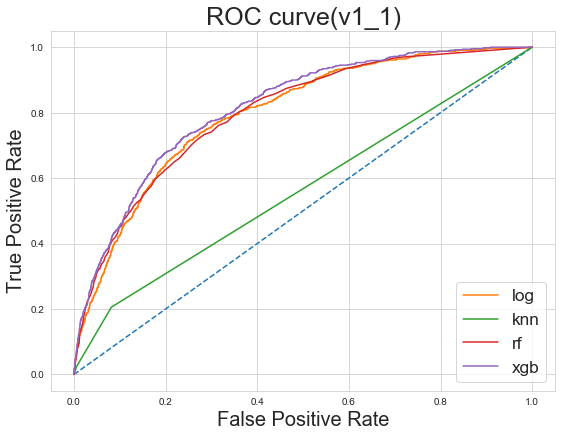

In [67]:
draw_chart(result1, case="v1_1")

## Submission

##### XGBOOST

In [79]:
# read model and submission_testset
xgb_v1_1 = pickle.load(open("xgb_v1_1", 'rb'))
xgb_v1_1_submission = xgb_v1_1.predict_proba(test_v1)[:, 1]


In [80]:
submission_file = pd.DataFrame(test_v1.index, columns=["CUS_ID"])
xgb_v1_1_submission = pd.DataFrame(xgb_v1_1_submission, columns=["Ypred"])

In [82]:
xgb_v1_1_submission = pd.concat([submission_file, xgb_v1_1_submission], axis=1)

In [84]:
# xgb_v1_1_submission.to_csv("xgb_v1_1_submission.csv", index=False)

##### Logistic regression

In [8]:
# read model and submission_testset
logmodel_v1_1 = pickle.load(open("logmodel_v1_1", 'rb'))
logmodel_v1_1_submission = logmodel_v1_1.predict_proba(test_v1)[:, 1]

In [9]:
submission_file = pd.DataFrame(test_v1.index, columns=["CUS_ID"])
logmodel_v1_1_submission = pd.DataFrame(logmodel_v1_1_submission, columns=["Ypred"])

In [10]:
logmodel_v1_1_submission = pd.concat([submission_file, logmodel_v1_1_submission], axis=1)

In [13]:
# logmodel_v1_1_submission.to_csv("logmodel_v1_1_submission.csv", index=False)

# Fit model2: After processing、tune
XGB、RF => only change occupation col from nominal to order
LOG、KNN => change occupation col from nominal to order、One-hot encoding

In [89]:
train_v1_proc_tree = pd.read_csv("train_cleaned_version1_proc_tree.csv", low_memory=False, index_col=0)
train_v1_proc_nontree = pd.read_csv("train_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

# 1. For tree

## use the same way to split(same random state)

In [90]:
X = train_v1_proc_tree.drop("Y1", axis=1)
y = train_v1_proc_tree["Y1"]

In [91]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [93]:
# 驗證分層抽樣比例
print(y_train.value_counts())
print(y_test.value_counts())
print("y_train 0比例:",65543*100/(65543 + 1294) )
print("y_train 1比例:",1294*100/(65543 + 1294) )
print("y_test 0比例:", 32284*100/(32284 + 637))
print("y_test 1比例:", 637*100/(32284 + 637))

0    65543
1     1294
Name: Y1, dtype: int64
0    32284
1      637
Name: Y1, dtype: int64
y_train 0比例: 98.06394661639511
y_train 1比例: 1.9360533836048894
y_test 0比例: 98.06506485222198
y_test 1比例: 1.9349351477780141


# Tune(Grid search )
參考:https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [94]:
# hyperparameter
param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25] , 
              "max_depth": [3, 5, 7, 9, 12], 
              "min_child_weight": [1, 3], 
              "gamma": [0.0, 0.1, 0.2], 
              "colsample_bytree": [0.3, 0.5, 0.7, 1] }


In [95]:
grid1 = GridSearchCV(XGBClassifier(), param_grid, verbose=5, scoring="roc_auc")
grid1.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8072611528133773, total=  11.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   12.0s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8119829813408141, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.5s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8114363050266157, total=  11.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   35.5s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8074879406708979, total=  12.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   48.2s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8120295485960372, total=  12.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8120220597645065, total=  12.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8137227791000448, total=  14.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8231134580110971, total=  13.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.82026181

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.830219379513102, total=  14.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8140969446309181, total=  17.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8297922218984403, total=  18.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.826856613123731, total=  17.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8154701739798202, t

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7990798907773573, total=  21.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8126801627103439, total=  23.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8058254638857858, total=  21.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.8004462333190935, total=  23.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.80929493

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7971022211253282, total=  26.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7872539960197777, total=  27.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7791006274834886, total=  24.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7945464912183821, total=  25.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.79909870

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8114363050266157, total=  11.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.807454089364905, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8118406246575156, total=  11.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8119931729385241, total=  11.0s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.813521366

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8227867179129881, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8322987296325339, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8310988346820755, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8133099414981624, total=  16.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8298888609001571,

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8237381601293391, total=  15.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8260132133864524, total=  15.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7961633279425526, total=  19.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8102112486098851, total=  19.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.81265220

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.8031587956614962, total=  18.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7697537468469018, total=  24.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7920960022462726, total=  24.5s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7853665286860518, total=  24.6s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.779420705

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8072605171081004, total=  10.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8119637066388232, total=  10.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8116060682300458, total=  10.7s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8074585922772828, total=  10.5s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.81195244

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8312782854924257, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.832897942312796, total=  13.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8224825329380094, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8334561144239763, total=  13.1s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8297645182054443, 

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8223647647842404, total=  16.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8067138105699988, total=  16.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8222321846531319, total=  16.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8222760864765367, total=  16.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.80009124

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7865684692725498, total=  18.8s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.799378122714116, total=  18.9s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.8037954740503377, total=  18.8s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.765709707728142, total=  24.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.791615249761907

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7790741091583189, total=  23.0s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7824847491896025, total=  23.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8113864032812564, total=  12.6s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8146180401865324, total=  12.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.81677

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8259182160855654, total=  12.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8175806625235634, total=  16.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8343933534455733, total=  16.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8324555596891565, total=  16.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.820931465037905, 

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8043090434585078, total=  20.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8176104509451931, total=  20.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8182191335502749, total=  20.8s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8048126809641022, total=  20.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.81907649

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.794870869054365, total=  25.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7867828327717217, total=  25.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.782258387495423, total=  25.0s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7984864951773952, total=  25.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7956491767201493, t

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7805138605256956, total=  32.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7650974705710838, total=  31.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7768265620898153, total=  31.7s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7770728766828833, total=  31.7s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8206807852570623, total=  12.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8281407569361317, total=  12.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8259794412884289, total=  12.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8204808029720494, total=  16.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8329122279983789,

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8276576150258994, total=  16.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8276802062689298, total=  16.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8069442007574217, total=  20.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8180821236112656, total=  21.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.81871413

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8142738515707796, total=  20.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7769597310373354, total=  25.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7930974371761532, total=  25.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.792037367658246, total=  25.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7838550672491422, 

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7725280176505689, total=  33.1s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.783037263999062, total=  32.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7857618109151209, total=  32.8s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7598175674186637, total=  31.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8294067809569767, total=  12.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8258575218905324, total=  12.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8206807852570623, total=  12.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8281407569361317, total=  12.7s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8260225591242705,

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8237190471553009, total=  16.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8142518977921531, total=  16.6s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8246451330899589, total=  16.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8301328783375037, total=  16.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.79942396

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7975931350610955, total=  20.7s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8011226159901653, total=  20.5s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8126073365953499, total=  20.7s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7821423712823955, total=  25.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.793615623999096, 

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7820170322523641, total=  25.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7819956909776566, total=  25.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7722679612168926, total=  32.9s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.775749143417376, total=  32.7s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.780

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8195302449847107, total=  40.7s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.820081738984499, total=  14.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8282464757561419, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8248140384026987, total=  14.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8226225470252383

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8138076987299456, total=  20.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8205553917766368, total=  19.9s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.824180917766322, total=  19.9s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8131803105971223, total=  19.8s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.826645294

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.807117048309306, total=  25.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8038416717315964, total=  25.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7887530704564872, total=  25.4s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8064153004814534, total=  25.5s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.805289092876137, t

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7828045752059487, total=  31.9s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.773205308647626, total=  31.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7862490771506321, total=  31.5s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7883255167210649, total=  31.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7638689

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8108938376425676, total=  40.2s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8188064382389699, total=  40.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.817894050556406, total=  40.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.820081738984499, total=  14.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.828246475

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8306973895150719, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.826982621281923, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8109689568161167, total=  19.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8217342283025264, total=  20.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.827565667

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8206105804159852, total=  19.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.79119190077573, total=  25.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8039756435732728, total=  25.6s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7957173581255933, total=  25.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7868178776428387, t

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7607232355364335, total=  31.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.78580241380863, total=  32.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7774858414727099, total=  31.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.766011561783772, total=  31.3s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.78871825674

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8205960120163696, total=  43.4s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8137634999448283, total=  44.0s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8106908357574895, total=  40.0s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8221434042075983, total=  40.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8273573535079493, total=  14.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8204432433852746, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8306973895150719, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.826982621281923, total=  14.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.811907045

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8053362902104778, total=  19.7s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8160262084972656, total=  19.7s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8213104487366633, total=  19.7s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7954184402843891, total=  25.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8032179831801411,

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.8001485798102221, total=  25.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7974431335749135, total=  25.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7702131498603144, total=  33.3s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7845816826825458, total=  31.8s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.78323304

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8021394872994563, total=  56.6s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8119540958370042, total=  57.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.803570167427831, total=  57.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8046306573531605, total=  53.1s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8111866653469956, 

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8225541752774012, total=  17.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8208108399616203, total=  18.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8274539297453571, total=  17.8s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8237016831992415, total=  18.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8119640474761654, total=  

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8202566604449557, total=  30.3s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8192274112189422, total=  32.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7911402497219848, total=  41.6s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7983107927286692, total=  40.7s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7968420858115026, total=  40.5s
[CV

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7646382264839904, total=  50.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7779349371018154, total=  51.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.785600809340895, total=  51.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7650900010340806, total=  52.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7838425536144685, total=  5

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.804939211816581, total=  58.9s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8061508935473372, total=  57.0s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8108902172444759, total=  55.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8122048857605684, total=  55.2s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8195648046435304, tota

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8291041734455564, total=  18.0s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8237016831992415, total=  17.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8143669604472652, total=  25.2s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8225330930172693, total=  25.2s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8236329707859671, total=  

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7895184596098295, total=  33.8s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8081508732342673, total=  46.5s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7989030334034724, total=  36.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7911694921647205, total=  34.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8047280472294979, total=  33.9s
[CV

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7786457218770022, total=  41.9s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7695907943942661, total=  41.4s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7752741786534427, total=  41.4s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7853037635604798, total=  41.4s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7665069880962068, total=

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8111940991163584, total=  54.0s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8138773480237005, total=  53.9s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8195648046435304, total=  17.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8257460212342436, total=  17.6s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.82454317130833, total=  17.6s

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8094778041383566, total=  25.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8186775685372296, total=  25.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8182109029289011, total=  25.5s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8095615583085832, total=  25.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8228336296929386, total=  

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.800734479411074, total=  35.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7859231754410947, total=  33.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.801813691049147, total=  34.0s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8040515260262336, total=  33.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7771556342134885, total=  42.7s
[CV] 

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7808491870854611, total=  45.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7932357461302539, total=  42.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7812274854381112, total=  58.5s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7910961602669699, total= 1.1min
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.784226879680104, tot

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 794.8min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25], 'max_depth': [3, 5, 7, 9, 12], 'min_child_weight': [1, 3], 'gamma': [0.0, 0.1, 0.2], 'colsample_bytree': [0.3, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [96]:
filename = "xgb_v1_2"
pickle.dump(grid1, open(filename, 'wb'))

In [97]:
xgb_v1_2 = pickle.load(open("xgb_v1_2", 'rb'))

In [101]:
xgb_v1_2.score(X_test, y_test)

0.8170848126332488

# 2.Logistic (略)

## Submission

##### Xgboost

In [8]:
# import test data
test_v1_proc_tree = pd.read_csv("test_cleaned_version1_proc_tree.csv", low_memory=False, index_col=0)

In [10]:
# read model and submission_testset
xgb_v1_2 = pickle.load(open("xgb_v1_2", 'rb'))
xgb_v1_2_submission = xgb_v1_2.predict_proba(test_v1_proc_tree)[:, 1]

In [11]:
submission_file = pd.DataFrame(test_v1_proc_tree.index, columns=["CUS_ID"])
xgb_v1_2_submission = pd.DataFrame(xgb_v1_2_submission, columns=["Ypred"])

In [12]:
xgb_v1_2_submission = pd.concat([submission_file, xgb_v1_2_submission], axis=1)

In [13]:
xgb_v1_2_submission.to_csv("xgb_v1_2_submission.csv", index=False)
# pd.read_csv("xgb_v1_2_submission.csv")

##### Logistic regression

In [6]:
# import test data
test_v1_proc_nontree = pd.read_csv("test_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

In [7]:
# read model and submission_testset
logmodel_v1_2 = pickle.load(open("logmodel_v1_2", 'rb'))
logmodel_v1_2_submission = logmodel_v1_2.predict_proba(test_v1_proc_nontree)[:, 1]

C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator LogisticRegression from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\user\Anaconda3\lib\site-packages\sklearn\base.py:251: UserWarning: Trying to unpickle estimator Pipeline from version 0.20.3 when using version 0.20.1. This might lead to breaking code or invalid results. Use at your o

In [8]:
submission_file = pd.DataFrame(test_v1_proc_nontree.index, columns=["CUS_ID"])
logmodel_v1_2_submission = pd.DataFrame(logmodel_v1_2_submission, columns=["Ypred"])

In [9]:
logmodel_v1_2_submission = pd.concat([submission_file, logmodel_v1_2_submission], axis=1)

In [12]:
# logmodel_v1_2_submission.to_csv("logmodel_v1_2_submission.csv", index=False)
# pd.read_csv("logmodel_v1_2_submission.csv")

# Fit model3: SMOTE + tune

##### Logistic

In [24]:
sm = SMOTE(random_state=105, ratio=1.0)

In [25]:
train_v1_proc_nontree = pd.read_csv("train_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

In [26]:
X = train_v1_proc_nontree.drop("Y1", axis=1)
y = train_v1_proc_nontree["Y1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

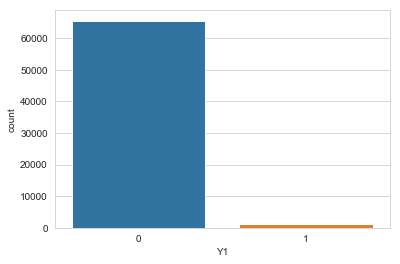

In [27]:
# original
sns.countplot(y_train, palette="viridis")

In [28]:
# 只由訓練資料產生虛擬樣本
X_train, y_train = sm.fit_sample(X_train, y_train)

In [41]:
X_test = np.array(X_test)

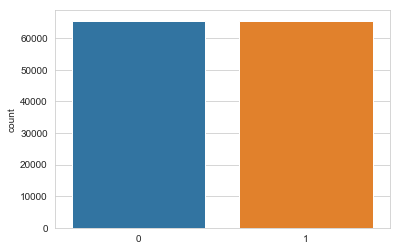

In [29]:
# after
sns.countplot(y_train, palette="viridis")

In [35]:
pipeline = Pipeline([
                     ('classifier', LogisticRegression())
                     ])
parameters = {    
              'classifier__penalty': [ 'l1', 'l2'],
              'classifier__C': [0.01, 0.1, 1, 10]
              }
scoring = 'roc_auc'
n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=123457)
grid2 = GridSearchCV(estimator=pipeline,
                        param_grid=parameters,
                        scoring=scoring, 
                        cv=cv,
                        return_train_score=True,
                        verbose=5, 
                        n_jobs=2)

In [43]:
grid2.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  2.7min finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=123457, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=1)

In [44]:
filename = "logmodel_v1_3"
pickle.dump(grid2, open(filename, 'wb'))

In [46]:
grid2.score(X_test, y_test)

0.7913819502620678

## Submission

##### Logistic regression

In [49]:
# import test data
test_v1_proc_nontree = pd.read_csv("test_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

In [50]:
# read model and submission_testset
logmodel_v1_3 = pickle.load(open("logmodel_v1_3", 'rb'))
logmodel_v1_3_submission = logmodel_v1_3.predict_proba(test_v1_proc_nontree)[:, 1]

In [51]:
submission_file = pd.DataFrame(test_v1_proc_nontree.index, columns=["CUS_ID"])
logmodel_v1_3_submission = pd.DataFrame(logmodel_v1_3_submission, columns=["Ypred"])
logmodel_v1_3_submission = pd.concat([submission_file, logmodel_v1_3_submission], axis=1)
# logmodel_v1_3_submission.to_csv("logmodel_v1_3_submission.csv", index=False)

In [53]:
# pd.read_csv("logmodel_v1_3_submission.csv")

# Fit model4: tree selection + tune

In [8]:
train_v1_proc_tree = pd.read_csv("train_cleaned_version1_proc_tree.csv", low_memory=False, index_col=0)
train_v1_proc_nontree = pd.read_csv("train_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

# import test data
test_v1_proc_tree = pd.read_csv("test_cleaned_version1_proc_tree.csv", low_memory=False, index_col=0)
test_v1_proc_nontree = pd.read_csv("test_cleaned_version1_proc_nontree.csv", low_memory=False, index_col=0)

##### XGBOOST

train_test_split

In [9]:
X = train_v1_proc_tree.drop("Y1", axis=1)
y = train_v1_proc_tree["Y1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

selection

In [10]:
fs = FeatureSelector(data = X_train, labels = y_train)

In [11]:
fs.identify_collinear(correlation_threshold = 0.98)

1 features with a correlation magnitude greater than 0.98.



In [12]:
fs.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,IF_ISSUE_INSD_H_IND,IF_ISSUE_H_IND,1.0


In [13]:
# zero importance feature
fs.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[46]	valid_0's auc: 0.828874	valid_0's binary_logloss: 0.0748846
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.802273	valid_0's binary_logloss: 0.0882544
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[160]	valid_0's auc: 0.807615	valid_0's binary_logloss: 0.0760991
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[89]	valid_0's auc: 0.840736	valid_0's binary_logloss: 0.074844
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[76]	valid_0's auc: 0.793802	valid_0's binary_logloss: 0.0757149
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[147]	valid_0's auc: 0.798699	valid_0's binary_loglos

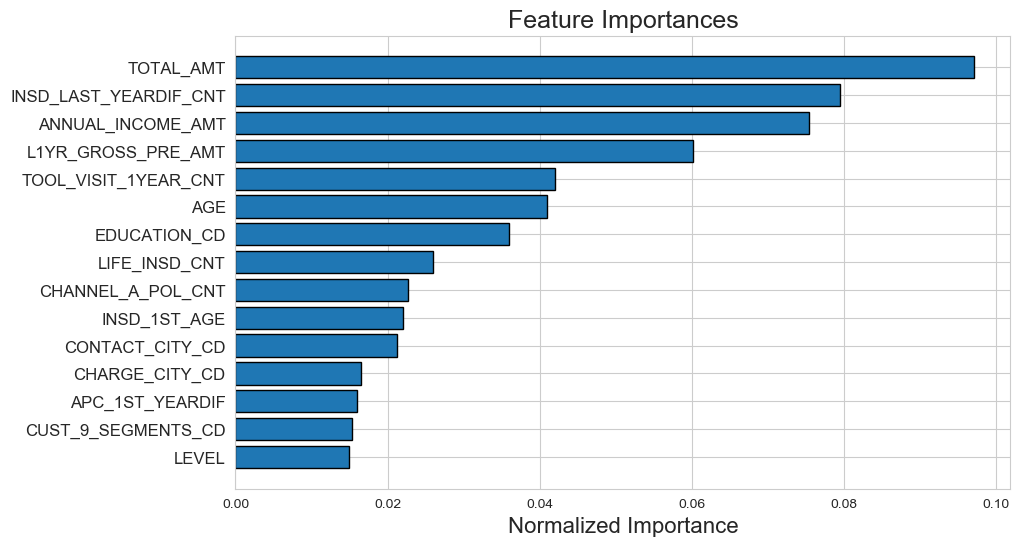

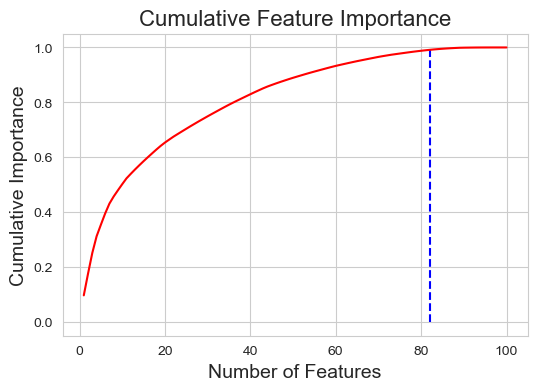

82 features required for 0.99 of cumulative importance


In [14]:
# draw importance(前15重要)
fs.plot_feature_importances(threshold = 0.99, plot_n = 15)

In [15]:
# importance df
fs.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,TOTAL_AMT,285.3,0.097041,0.097041
1,INSD_LAST_YEARDIF_CNT,233.8,0.079524,0.176565
2,ANNUAL_INCOME_AMT,221.6,0.075374,0.251939
3,L1YR_GROSS_PRE_AMT,176.9,0.060170,0.312109
4,TOOL_VISIT_1YEAR_CNT,123.7,0.042075,0.354184
5,AGE,120.3,0.040918,0.395102
6,EDUCATION_CD,105.9,0.036020,0.431122
7,LIFE_INSD_CNT,76.5,0.026020,0.457143
8,CHANNEL_A_POL_CNT,66.8,0.022721,0.479864
9,INSD_1ST_AGE,64.9,0.022075,0.501939


In [16]:
# single_unique value
fs.identify_single_unique()

0 features with a single unique value.



In [17]:
fs.record_zero_importance

,feature,importance,normalized_importance,cumulative_importance
97,IF_ISSUE_E_IND,0.0,0.0,1.0
98,IF_ISSUE_INSD_H_IND,0.0,0.0,1.0
99,IF_ISSUE_M_IND,0.0,0.0,1.0


In [18]:
# remove all 
X_train = fs.remove(methods = 'all')

['collinear', 'zero_importance', 'single_unique'] methods have been run

Removed 3 features.


In [19]:
# 對應調整X_test
X_test = X_test[X_train.columns]

In [20]:
# 對應調整test
test_v1_proc_tree_selection = test_v1_proc_tree[X_train.columns]

tune

In [21]:
# hyperparameter
param_grid = {"learning_rate": [0.05, 0.10, 0.15, 0.20, 0.25] , 
              "max_depth": [3, 5, 7, 9, 12], 
              "min_child_weight": [1, 3], 
              "gamma": [0.0, 0.1, 0.2], 
              "colsample_bytree": [0.3, 0.5, 0.7, 1] }
grid3 = GridSearchCV(XGBClassifier(), param_grid, verbose=5, scoring="roc_auc")
grid3.fit(X_train, y_train)

C:\Users\user\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 600 candidates, totalling 1800 fits
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8058307099895574, total=  10.6s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.0s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8105908487325636, total=  10.7s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   22.1s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8095137380752899, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   32.9s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.805648262575098, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   43.7s remaining:    0.0s


[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8106982136015042, total=  10.4s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8104491614696046, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8142366938409482, total=  13.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.8250657782391907, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.82100002

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8309786145092367, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8142823056945632, total=  16.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8277960424311059, total=  16.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8265212285779494, total=  16.1s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.1, max_depth=7, min_child_weight=3, score=0.8176042365942471,

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7922333449455499, total=  18.9s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8093484534786218, total=  19.0s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8028760870925058, total=  19.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.8010368035212987, total=  18.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.15, max_depth=9, min_child_weight=3, score=0.81740182

[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7933791239366523, total=  23.8s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7811505920153202, total=  24.2s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7789801083580834, total=  22.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.7934730549223872, total=  22.5s
[CV] colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.0, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.79259365

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8095174020293208, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.805648262575098, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8106895585700316, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8104491614696046, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.05, max_depth=5, min_child_weight=1, score=0.814105208

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8224852346854361, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8349310804622699, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8325940465313666, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.814718134637292, total=  15.9s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.1, max_depth=7, min_child_weight=1, score=0.8300599437922078, 

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8284348687111373, total=  16.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8240089774307865, total=  16.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.7885019138966869, total=  19.3s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.8089457555725659, total=  20.2s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.80203327

[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7897095355306367, total=  18.4s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7780968488513229, total=  23.8s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7941436340172685, total=  23.7s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7816562176715796, total=  24.1s
[CV] colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.1, learning_rate=0.2, max_depth=12, min_child_weight=3, score=0.773284824

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8058307099895574, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8105589366226559, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.80955648420565, total=  10.3s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8056128749813527, total=  10.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.05, max_depth=3, min_child_weight=3, score=0.8106895585

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.832903254376791, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8298336023242001, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8223485580509107, total=  12.9s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8349689926860204, total=  13.0s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.831755425864563, t

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8222864411292327, total=  15.8s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8101473077457721, total=  15.5s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.823996218122935, total=  15.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8269566549990086, total=  15.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.15, max_depth=9, min_child_weight=1, score=0.795859990

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7939721048286478, total=  18.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.8021901052706699, total=  18.4s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7958132581397924, total=  18.5s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7822712605272794, total=  23.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.2, max_depth=12, min_child_weight=1, score=0.7878078323893

[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7892343727300454, total=  23.6s
[CV] colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.3, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7775832814096175, total=  22.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8115106306874433, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.813860220498343, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.814558

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8270894600574317, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8217151307179571, total=  16.2s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8354714623965962, total=  16.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8284432645214446, total=  16.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.1, max_depth=5, min_child_weight=3, score=0.8220609543885702,

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8005478402125121, total=  20.5s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8207492538619494, total=  20.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8199848407884532, total=  20.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.8121647184418948, total=  20.1s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.15, max_depth=7, min_child_weight=3, score=0.82055438

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7970802384073554, total=  24.6s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7839426842891882, total=  24.9s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7895749314285908, total=  24.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7989023614748938, total=  24.3s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.7915429993679945,

[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7741336952399501, total=  31.8s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7607786478464, total=  31.0s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7799686040060796, total=  30.4s
[CV] colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7776526841330719, total=  30.5s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.05, max_depth=3, min_child_weight=1, score=0.8115

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.81898541225911, total=  12.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.827074701311147, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.827105868199396, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8175798678919675, total=  16.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.1, max_depth=5, min_child_weight=1, score=0.8312823740655753, tot

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8285358086794142, total=  16.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8276230698263615, total=  16.0s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8036226936612555, total=  20.6s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.8147682554260145, total=  20.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.81763863

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8063808980765516, total=  20.2s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7835902430258893, total=  24.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7941237221350466, total=  24.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7888851989744752, total=  25.0s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.2, max_depth=9, min_child_weight=3, score=0.784077775997803, 

[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7684397970150669, total=  32.0s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7867692817109734, total=  31.9s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.774319335577514, total=  32.3s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.7618187676302264, total=  30.4s
[CV] colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=3, score=0.

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8264730438779299, total=  12.2s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.828213178828463, total=  12.2s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8187402419240002, total=  12.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8270608957394732, total=  12.2s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.8274237294867692, 

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8279323287868796, total=  16.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8143976332268739, total=  16.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8288898153961434, total=  15.8s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8265423095888226, total=  16.3s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.15, max_depth=7, min_child_weight=1, score=0.80992094

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7978581711861074, total=  19.8s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8166818669550686, total=  20.0s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.806477966307978, total=  19.9s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7763768422738924, total=  24.8s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.7968158617098009, 

[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7805598541621886, total=  24.1s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7891772532812832, total=  24.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7745756243473426, total=  31.9s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7842749334996232, total=  31.4s
[CV] colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.5, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.77

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8170781570247503, total=  38.8s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8215661108059726, total=  14.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8278280076393663, total=  14.0s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8254947373406938, total=  14.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.1, max_depth=3, min_child_weight=3, score=0.822491379836445

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8124827300066453, total=  19.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8238670298310793, total=  19.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.823847232445598, total=  19.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8150396425810652, total=  19.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.828929639

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8016538650078457, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.795121567339705, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7813592353567409, total=  24.7s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.803413597511089, total=  24.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8090947728969781, t

[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7781590532002939, total=  30.9s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7754038423722147, total=  30.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7783167142569501, total=  30.3s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7772350464743364, total=  30.1s
[CV] colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.0, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.766314

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8138503969343749, total=  39.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8211831205009765, total=  39.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8162384743422858, total=  38.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8215661108059726, total=  14.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8278280

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8287731583154995, total=  13.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8283047776792345, total=  14.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8101221444118963, total=  19.1s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8256600019030449, total=  19.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.82762269

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.82023691020562, total=  19.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7813388398124415, total=  25.0s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8101370702113144, total=  24.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7910930233323779, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7897281364003146, t

[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7646178309396909, total=  30.9s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7915228586283973, total=  31.2s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7807995958393199, total=  30.8s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7669212560349621, total=  30.7s
[CV] colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.78267693

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8221794579890083, total=  42.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8170931845463552, total=  42.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8145040079098689, total=  38.7s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8189184757629384, total=  39.3s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8271127182004102, total=  14.1s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8184301766752105, total=  14.0s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8287867514937628, total=  14.0s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8288340862847368, total=  13.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.80974013

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8067539129778809, total=  19.2s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8240858481421098, total=  18.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8211445087896133, total=  18.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7870058874784708, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8040362287935799,

[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7998598840671809, total=  24.6s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=7, min_child_weight=3, score=0.7909913884336086, total=  24.9s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7726559533375374, total=  30.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7751599109986653, total=  30.5s
[CV] colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=0.7, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.77040283

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8019211755122937, total=  55.3s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8119540958370042, total=  56.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8020125621584491, total=  56.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8046306573531605, total=  51.6s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8111866653469956,

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=1, score=0.8225541752774012, total=  16.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8208108399616203, total=  17.0s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8274539297453571, total=  16.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8237016831992415, total=  16.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8112908355879681, total=  

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8202566604449557, total=  24.8s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=5, min_child_weight=3, score=0.8192274112189422, total=  24.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7891287722751129, total=  32.2s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7983107927286692, total=  32.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7968932218655855, total=  32.4s
[CV

[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7776368101326336, total=  39.9s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7779349371018154, total=  40.5s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.783033227177788, total=  40.3s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7650900010340806, total=  39.4s
[CV] colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.0, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7838425536144685, total=  3

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=1, score=0.8021716521044848, total=  55.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8061508935473372, total=  51.8s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8108902172444759, total=  52.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8122048857605684, total=  51.9s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8195648046435304, tot

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8291041734455564, total=  16.9s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=3, min_child_weight=3, score=0.8237016831992415, total=  17.2s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8143669604472652, total=  24.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8225330930172693, total=  24.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8236329707859671, total=  

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7880091893316787, total=  31.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.8081508732342673, total=  31.7s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7963749582229589, total=  32.0s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7911694921647205, total=  31.4s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8047280472294979, total=  31.7s
[CV

[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=1, score=0.7862045652442419, total=  40.1s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7695907943942661, total=  39.3s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7752741786534427, total=  39.3s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7853037635604798, total=  39.4s
[CV] colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.1, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7761458693566323, total=

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8111940991163584, total=  52.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.05, max_depth=12, min_child_weight=3, score=0.8138773480237005, total=  51.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8195648046435304, total=  17.0s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.8257460212342436, total=  17.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.1, max_depth=3, min_child_weight=1, score=0.82454317130833, total=  17.2s

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8094778041383566, total=  24.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8186775685372296, total=  24.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=1, score=0.8182109029289011, total=  24.0s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8095615583085832, total=  24.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.15, max_depth=5, min_child_weight=3, score=0.8228336296929386, total=  

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=1, score=0.7937174233333548, total=  37.3s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.7859231754410947, total=  37.7s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.801813691049147, total=  36.1s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=7, min_child_weight=3, score=0.8040515260262336, total=  36.8s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.2, max_depth=9, min_child_weight=1, score=0.777958847830804, total=  46.4s
[CV] 

[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7808491870854611, total=  39.5s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=9, min_child_weight=3, score=0.7932357461302539, total=  39.4s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7744261276564004, total=  52.9s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.7910961602669699, total=  52.9s
[CV] colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1 
[CV]  colsample_bytree=1, gamma=0.2, learning_rate=0.25, max_depth=12, min_child_weight=1, score=0.784226879680104, tot

[Parallel(n_jobs=1)]: Done 1800 out of 1800 | elapsed: 747.5min finished


GridSearchCV(cv='warn', error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=1, gamma=0, learning_rate=0.1,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
       subsample=1, verbosity=1),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25], 'max_depth': [3, 5, 7, 9, 12], 'min_child_weight': [1, 3], 'gamma': [0.0, 0.1, 0.2], 'colsample_bytree': [0.3, 0.5, 0.7, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=5)

In [22]:
filename = "xgb_v1_4"
pickle.dump(grid3, open(filename, 'wb'))

In [23]:
grid3.score(X_test, y_test)

0.818162108967373

Submission

In [24]:
# read model and submission_testset
xgb_v1_4 = pickle.load(open("xgb_v1_4", 'rb'))
xgb_v1_4_submission = xgb_v1_4.predict_proba(test_v1_proc_tree_selection)[:, 1]
submission_file = pd.DataFrame(test_v1_proc_tree_selection.index, columns=["CUS_ID"])
xgb_v1_4_submission = pd.DataFrame(xgb_v1_4_submission, columns=["Ypred"])
xgb_v1_4_submission = pd.concat([submission_file, xgb_v1_4_submission], axis=1)

In [25]:
xgb_v1_4_submission.to_csv("xgb_v1_4_submission.csv", index=False)

In [27]:
# pd.read_csv("xgb_v1_4_submission.csv")

##### Logistic Regression

train_test_split

In [16]:
X = train_v1_proc_nontree.drop("Y1", axis=1)
y = train_v1_proc_nontree["Y1"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)

In [17]:
fs2 = FeatureSelector(data = X_train, labels = y_train)

In [18]:
fs2.identify_collinear(correlation_threshold = 0.98)

1 features with a correlation magnitude greater than 0.98.



In [19]:
fs2.record_collinear.head()

,drop_feature,corr_feature,corr_value
0,IF_ISSUE_INSD_H_IND,IF_ISSUE_H_IND,1.0


In [20]:
# zero importance feature
fs2.identify_zero_importance(task = 'classification', 
                            eval_metric = 'auc', 
                            n_iterations = 10, 
                             early_stopping = True)

Training Gradient Boosting Model

Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[28]	valid_0's auc: 0.809465	valid_0's binary_logloss: 0.0826832
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[139]	valid_0's auc: 0.851485	valid_0's binary_logloss: 0.079867
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[66]	valid_0's auc: 0.839427	valid_0's binary_logloss: 0.0797186
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[78]	valid_0's auc: 0.808503	valid_0's binary_logloss: 0.0834095
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[75]	valid_0's auc: 0.827903	valid_0's binary_logloss: 0.0785404
Training until validation scores don't improve for 100 rounds.
Early stopping, best iteration is:
[117]	valid_0's auc: 0.82133	valid_0's binary_logloss

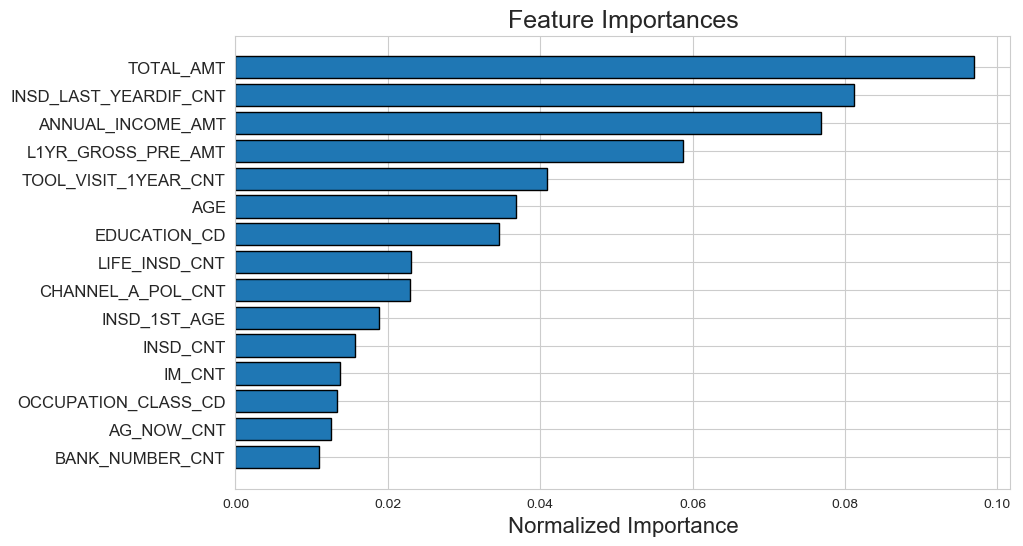

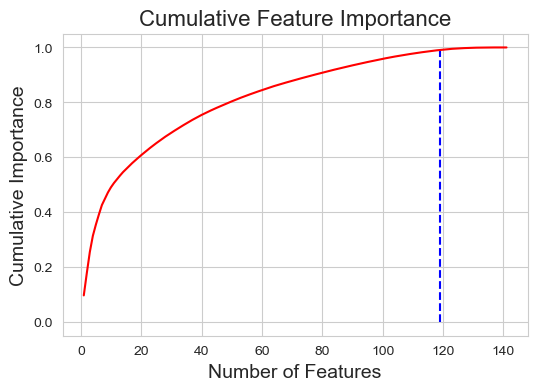

119 features required for 0.99 of cumulative importance


In [21]:
# draw importance(前15重要)
fs2.plot_feature_importances(threshold = 0.99, plot_n = 15)

In [22]:
# importance df
fs2.feature_importances.head(10)

,feature,importance,normalized_importance,cumulative_importance
0,TOTAL_AMT,297.9,0.096878,0.096878
1,INSD_LAST_YEARDIF_CNT,249.8,0.081236,0.178114
2,ANNUAL_INCOME_AMT,236.5,0.076911,0.255024
3,L1YR_GROSS_PRE_AMT,180.5,0.058699,0.313724
4,TOOL_VISIT_1YEAR_CNT,125.7,0.040878,0.354602
5,AGE,113.3,0.036846,0.391447
6,EDUCATION_CD,106.2,0.034537,0.425984
7,LIFE_INSD_CNT,70.7,0.022992,0.448976
8,CHANNEL_A_POL_CNT,70.4,0.022894,0.471870
9,INSD_1ST_AGE,57.9,0.018829,0.490699


In [23]:
# single_unique value
fs2.identify_single_unique()

0 features with a single unique value.



In [25]:
# remove all 
X_train = fs2.remove(methods = 'all')

['collinear', 'zero_importance', 'single_unique'] methods have been run

Removed 4 features.


In [26]:
# 對應調整X_test
X_test = X_test[X_train.columns]

In [27]:
# 對應調整test
test_v1_proc_nontree_selection = test_v1_proc_nontree[X_train.columns]

In [28]:
# 檢查欄位順序
print(sum(X_test.columns == X_train.columns) == len(X_test.columns))
print(sum(X_test.columns == test_v1_proc_nontree_selection.columns) == len(X_test.columns))

True
True


tune

In [29]:
pipeline = Pipeline([
                     ('classifier', LogisticRegression())
                     ])
parameters = {    
              'classifier__penalty': [ 'l1', 'l2'],
              'classifier__C': [0.01, 0.1, 1, 10]
              }
scoring = 'roc_auc'
n_splits = 3
cv = KFold(n_splits=n_splits, shuffle=True, random_state=123457)
grid4 = GridSearchCV(estimator=pipeline,
                        param_grid=parameters,
                        scoring=scoring, 
                        cv=cv,
                        return_train_score=True,
                        verbose=5, 
                        n_jobs=2)


In [30]:
grid4.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  14 tasks      | elapsed:   24.6s
[Parallel(n_jobs=2)]: Done  24 out of  24 | elapsed:  1.4min finished
C:\Users\user\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


GridSearchCV(cv=KFold(n_splits=3, random_state=123457, shuffle=True),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('classifier', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=2,
       param_grid={'classifier__penalty': ['l1', 'l2'], 'classifier__C': [0.01, 0.1, 1, 10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='roc_auc', verbose=5)

In [31]:
grid4.score(X_test, y_test)

0.8013719536211881

In [32]:
filename = "logmodel_v1_4"
pickle.dump(grid4, open(filename, 'wb'))

Submission

In [33]:
# read model and submission_testset
logmodel_v1_4 = pickle.load(open("logmodel_v1_4", 'rb'))
logmodel_v1_4_submission = logmodel_v1_4.predict_proba(test_v1_proc_nontree_selection)[:, 1]
submission_file = pd.DataFrame(test_v1_proc_nontree_selection.index, columns=["CUS_ID"])
logmodel_v1_4_submission = pd.DataFrame(logmodel_v1_4_submission, columns=["Ypred"])
logmodel_v1_4_submission = pd.concat([submission_file, logmodel_v1_4_submission], axis=1)
# logmodel_v1_4_submission.to_csv("logmodel_v1_4_submission.csv", index=False)

In [35]:
# pd.read_csv("logmodel_v1_4_submission.csv")